# Exploring phonological areality using a naive Bayes classifier

This homework replicates the analyses of Michael et al. 2014, who use a naive Bayes classifier to probe areality in the circum-Andean region, based on phoneme inventories.  

The central dataset is the [South American Phonological Inventory Database (SAPhon)](http://linguistics.berkeley.edu/~saphon/en/).  The data have been downloaded for you, in [YAML](https://en.wikipedia.org/wiki/YAML) format.  There is YAML support in Python, which is used here, so our treatment of YAML is roughly analogous to our treatment of XML: someone else has gone to the trouble of creating reliable and flexible routines to read files in this format, so we'll use their routines to keep life easy.

We will take the same approach to the naive Bayes classifier itself - again, [the relevant routines have been written for you](https://scikit-learn.org/stable/modules/naive_bayes.html) and are available in [scikit-learn](https://scikit-learn.org/stable/index.html), a standard machine learning library for Python.  This allows us to focus our attention on the high-level questions of data, training, testing, and generalization, in the specific case of phonological areality in South America.

Thanks to [Geoff Bacon](https://geoffbacon.github.io/) for creating the first draft of this homework.

In [1]:
import glob
from io import StringIO
import re
import yaml
import pandas as pd
from sklearn.naive_bayes import BernoulliNB
import seaborn as sns
import matplotlib.pyplot as plt
import math
from scipy.stats import gaussian_kde
import numpy as np

### Read in SAPhon data

- Read in the YAML files of the SAPhon dataset.  Each file corresponds to a language, and the critical information we care about is: (a) the language's name, (b) its ISO code, and (c) the list of phonemes in the language.
- Then store this information in a Pandas dataframe.

In [2]:
# read in SAPhon data.
# we construct the list `features`, which is a list of dicts, each dict containing
# the relevant information from the files.
features = []
filenames = glob.glob("data/saphon/*.yaml")
for filename in filenames:
    with open(filename) as file:
        data = list(yaml.safe_load_all(file))[0]
    this_language = {}
    this_language["name"] = data["name"]
    this_language["iso"] = data["iso_codes"][0]
    phonemes = data["phonemes"]
    for phoneme in phonemes:
        this_language[phoneme] = 1
    features.append(this_language)

features

[{'name': 'Abipon',
  'iso': 'axb',
  'p': 1,
  't': 1,
  'c': 1,
  'k': 1,
  'q': 1,
  'm': 1,
  'n': 1,
  'ɲ': 1,
  'ɣ': 1,
  'ʁ': 1,
  'h': 1,
  'l': 1,
  'ɾ': 1,
  'i': 1,
  'iː': 1,
  'e': 1,
  'eː': 1,
  'o': 1,
  'oː': 1,
  'ə': 1,
  'əː': 1,
  'a': 1,
  'aː': 1},
 {'name': 'Achagua',
  'iso': 'aca',
  'p': 1,
  'b': 1,
  't': 1,
  'd': 1,
  'k': 1,
  'kʷ': 1,
  'ʔ': 1,
  'ts': 1,
  'tʃ': 1,
  'm': 1,
  'n': 1,
  's': 1,
  'ʃ': 1,
  'ʒ': 1,
  'h': 1,
  'j': 1,
  'w': 1,
  'l': 1,
  'ɾ': 1,
  'i': 1,
  'iː': 1,
  'u': 1,
  'uː': 1,
  'e': 1,
  'eː': 1,
  'o': 1,
  'oː': 1,
  'a': 1,
  'aː': 1},
 {'name': 'Aché',
  'iso': 'guq',
  'p': 1,
  'b': 1,
  't': 1,
  'd': 1,
  'k': 1,
  'ɡ': 1,
  'ʔ': 1,
  'tʃ': 1,
  'dʒ': 1,
  'mb': 1,
  'nd': 1,
  'ŋɡ': 1,
  'ndʒ': 1,
  'm': 1,
  'n': 1,
  'ɲ': 1,
  'ɸ': 1,
  'β': 1,
  'v': 1,
  'j': 1,
  'w': 1,
  'ɾ': 1,
  'i': 1,
  'ĩ': 1,
  'ɨ': 1,
  'ɨ̃': 1,
  'u': 1,
  'ũ': 1,
  'e': 1,
  'ẽ': 1,
  'o': 1,
  'õ': 1,
  'a': 1,
  'ã': 1},
 {'n

In [3]:
# now we turn the `features` list into a dataframe.
# YOUR CODE GOES HERE.
features = pd.DataFrame(features)  # REPLACE WITH YOUR CODE.
features.head()

,name,iso,p,t,c,k,q,m,n,ɲ,...,ø,kʲʼ,ɐ̃,bʲ,ɺ̥,r̥,h̃,c̰,k̰,ʒ̺
0,Abipon,axb,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Achagua,aca,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aché,guq,1.0,1.0,NaN,1.0,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Achuar-Shiwiar,acu,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Aguaruna,agr,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# now clean the data up a little.
# first replace NaN by 0 - this denotes absence of a given phoneme.
# YOUR CODE GOES HERE.
features=features.fillna(0)
features.head()

,name,iso,p,t,c,k,q,m,n,ɲ,...,ø,kʲʼ,ɐ̃,bʲ,ɺ̥,r̥,h̃,c̰,k̰,ʒ̺
0,Abipon,axb,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Achagua,aca,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aché,guq,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Achuar-Shiwiar,acu,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aguaruna,agr,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
col_names = features.columns.tolist()
phoneme_columns = col_names[2:]
phoneme_columns

['p',
 't',
 'c',
 'k',
 'q',
 'm',
 'n',
 'ɲ',
 'ɣ',
 'ʁ',
 'h',
 'l',
 'ɾ',
 'i',
 'iː',
 'e',
 'eː',
 'o',
 'oː',
 'ə',
 'əː',
 'a',
 'aː',
 'b',
 'd',
 'kʷ',
 'ʔ',
 'ts',
 'tʃ',
 's',
 'ʃ',
 'ʒ',
 'j',
 'w',
 'u',
 'uː',
 'ɡ',
 'dʒ',
 'mb',
 'nd',
 'ŋɡ',
 'ndʒ',
 'ɸ',
 'β',
 'v',
 'ĩ',
 'ɨ',
 'ɨ̃',
 'ũ',
 'ẽ',
 'õ',
 'ã',
 'ŋ',
 'x',
 'ɨː',
 'β̞',
 'ɰ',
 'tˣ',
 'ð̞',
 'y',
 'kʲ',
 'ɛ',
 'ɛ̃',
 'ɔ',
 'pʼ',
 'tʼ',
 'kʼ',
 'tʃʼ',
 'f',
 'ɬ',
 'æ',
 'ĩː',
 'ẽː',
 'õː',
 'ãː',
 'ŋʷ',
 'ʈʂ',
 'ʎ',
 'pʲ',
 'tʲ',
 'hʷ',
 'ɾʲ',
 'o̝',
 'ɟ',
 'ɯ',
 'ɯː',
 'ɤ',
 'ɤ̃',
 'ɤː',
 'ɑ',
 'ɑː',
 'ɒ',
 'ɒ̃',
 'ɒː',
 'z',
 'ɘ',
 'ə̃',
 'ʌ',
 'ɨ̃ː',
 'kʷʲ',
 'mʲ',
 'hʲ',
 'ɪ',
 'ɪː',
 'N',
 'tʰ',
 'tsʰ',
 'tʃʰ',
 'ç',
 'ʋ',
 'wʲ',
 'βʲ',
 'ʐ',
 'ɔ̃',
 'χ',
 'pʰ',
 'kʰ',
 'qʰ',
 'qʼ',
 'm̥',
 'n̥',
 'ɲ̥',
 'dz',
 'ʂ',
 'ɺ',
 'r',
 't̪',
 'ɻ',
 'ʰm',
 'ʰn',
 'ʰw',
 'kp',
 'ʔʲ',
 'pʲʰ',
 'tʲʰ',
 'kʲʰ',
 'ɛː',
 'ɡʷ',
 'ɽʰ',
 'ɽ',
 'b̰',
 'd̰',
 'ɡ̰',
 'j̰',
 'w̰',
 'mp',
 'nt',
 'ŋk',
 'ntʃ',
 'ɳ

In [6]:
# now focus on the columns that hold phonemes, and convert the floats to ints.
# YOUR CODE GOES HERE.
features[phoneme_columns]=features[phoneme_columns].astype(int)
features.head()

,name,iso,p,t,c,k,q,m,n,ɲ,...,ø,kʲʼ,ɐ̃,bʲ,ɺ̥,r̥,h̃,c̰,k̰,ʒ̺
0,Abipon,axb,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Achagua,aca,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Aché,guq,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,Achuar-Shiwiar,acu,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Aguaruna,agr,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# there's a phoneme called "N", which will conflict with the name of one of the three classes in 
# michael et al.'s two-core analysis. 
# so to simplify matters, let's rename the phoneme to something else.
features.rename({"N": "NN"}, axis=1, inplace=True)
phoneme_columns[phoneme_columns.index("N")] = "NN"
features.head()

,name,iso,p,t,c,k,q,m,n,ɲ,...,ø,kʲʼ,ɐ̃,bʲ,ɺ̥,r̥,h̃,c̰,k̰,ʒ̺
0,Abipon,axb,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,Achagua,aca,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Aché,guq,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,Achuar-Shiwiar,acu,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Aguaruna,agr,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
features.shape

(363, 306)

### Read in classification data

- Now read in the classification data, specifying which areal classes the various languages fall into.  
- The labeled data for this classification were copied from the publisher's webpage for the article.  Appendix C1 (data in file 'appendix_c1.txt') provides classes for the one-core analysis;  we will focus on this.  If you wish to extend to the two-core analysis, the relevant data are from Appendix C2, and can be found in the file 'appendix_c2.txt'.

In [9]:
# read in classification data for the one-core analysis.
# use regular expressions to wrangle the txt file into a csv, then read with Pandas.
with open("data/appendix_c1.txt") as file:
    contents = file.read()
contents = re.sub(r" ", ",", contents)
contents = re.sub(r"\n\n", "\n", contents)
contents = re.sub(r"^([a-z])", r",\1", contents, flags=re.MULTILINE)
labels = pd.read_csv(StringIO(contents), names=["label", "iso", "NBC_score"])
labels.head()

,label,iso,NBC_score
0,A,ayr,56.64
1,A,caw,54.43
2,A,ayr_chl,49.00
3,A,ayr_muy,46.82
4,A,cap,46.43


In [10]:
labels.shape

(359, 3)

In [11]:
# we retain the NBC score because this is what we want to replicate.  we will check our results against it.
# now merge in the features data to create a single dataframe, with both features and labels 
# for the one core analysis.
# YOUR CODE GOES HERE.
one_core_data = pd.merge(features, labels, on='iso')
one_core_data.head()

,name,iso,p,t,c,k,q,m,n,ɲ,...,ɐ̃,bʲ,ɺ̥,r̥,h̃,c̰,k̰,ʒ̺,label,NBC_score
0,Abipon,axb,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,NaN,-16.13
1,Achagua,aca,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,NaN,-4.37
2,Aché,guq,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,C,-57.35
3,Achuar-Shiwiar,acu,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,NaN,-26.68
4,Aguaruna,agr,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,NaN,-31.13


### One core analysis

In this homework we will replicate only the one-core analysis.

In the one-core analysis, there are two classes, or labels, for languages: A (Andean core) and C (control class, i.e. not Andean core).  Not all languages have a label - those languages that have a class label constitute our **training set**, and those that don't have a class label constitute our **test set**.  The essence of Michael et al.'s core-plus-periphery idea is that they train a classifier on a training set: a set of languages that we are fairly certain either do (label A) or don't (label C) belong to the Andean core.  They then ask which other languages, in the test set, are also rated as "core-like" by the classifier: that is, to which other languages the classifier assigns a high probability of belonging to the core (label A).

The input to the classifier is the phoneme inventory of a specific language, encoded as a binary vector (i.e. each element is either 0 or 1).  This format is already given to us in the dataframe above.  We denote this input feature vector by $x_1,...,x_n$, assuming there are $n$ features total (here, each feature is a phoneme that either is (1) or is not (0) in the inventory of the language).  Given input $x_1,...,x_n$, the classifier  determines the probability that the class $y$ is A for Andean core vs. C for control.  It does so using the conditional independence assumption that puts the "naive" in naive Bayes:

\begin{equation}
P(y | x_1,...,x_n) \propto P(y) \prod_{i=1}^n P(x_i|y)
\end{equation}

The classifications we obtain will obviously depend on the values $P(y)$ and $P(x_i|y)$.  Following Michael et al., we assume $P(y)$ is uniform, and $P(x_i|y)$ is inferred by training on the training set.  Then, once the classifier has been trained, we use it to classify the remaining languages in the test set, and we compare our results to those reported by Michael et al.

### Prepare training and test sets

In [12]:
# split data into training set vs. test set.
# data in training set has a class label; test set does not.
# create a boolean vector is_training to separate training from test.
# YOUR CODE GOES HERE.
is_training = one_core_data["label"].notnull()
train = one_core_data[is_training]
test = one_core_data[~is_training]

display(is_training)
display(train.head())
display(test.head())
print("Number of languages in training set:", len(train))
print("Number of languages in test set:", len(test))

0      False
1      False
2       True
3      False
4      False
       ...  
349    False
350    False
351    False
352    False
353     True
Name: label, Length: 354, dtype: bool

,name,iso,p,t,c,k,q,m,n,ɲ,...,ɐ̃,bʲ,ɺ̥,r̥,h̃,c̰,k̰,ʒ̺,label,NBC_score
2,Aché,guq,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,C,-57.35
8,Akurio,ako,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,C,-28.68
9,Alacalufe (Central),alc_cnt,1,1,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,C,4.76
10,Alacalufe (Southern),alc_sth,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,C,5.69
14,Ancash Quechua (Sihuas and Corongo dialects),qwa,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,A,23.87


,name,iso,p,t,c,k,q,m,n,ɲ,...,ɐ̃,bʲ,ɺ̥,r̥,h̃,c̰,k̰,ʒ̺,label,NBC_score
0,Abipon,axb,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,NaN,-16.13
1,Achagua,aca,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,NaN,-4.37
3,Achuar-Shiwiar,acu,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,NaN,-26.68
4,Aguaruna,agr,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,NaN,-31.13
5,Aikanã,tba,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,NaN,-35.30


Number of languages in training set: 133
Number of languages in test set: 221


In [13]:
# now get training and test data in appropriate format to feed to the model.
# specifically, pull out input feature vectors X, for both training and testing, separately.
# and similarly pull out output classes y, for both training and testing, separately.
X_train, X_test = train.loc[:,phoneme_columns], test.loc[:,phoneme_columns]
y_train, y_test = train.loc[:,"label"], test.loc[:,"label"]
display(X_train.head())
display(y_train.head())

,p,t,c,k,q,m,n,ɲ,ɣ,ʁ,...,ø,kʲʼ,ɐ̃,bʲ,ɺ̥,r̥,h̃,c̰,k̰,ʒ̺
2,1,1,0,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,1,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,1,1,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,1,1,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


2     C
8     C
9     C
10    C
14    A
Name: label, dtype: object

### Train the model.

There are [several variants](https://scikit-learn.org/stable/modules/naive_bayes.html) of naive Bayes available in the scikit-learn library.  We will be using the <span style="font-family:Courier New">BernoulliNB</span> routine, which is [Bernoulli naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB), following Michael et al., p. 70.  We are asking that the prior over classes be uniform, not fit to the data, following Michael et al., p. 70.  An important difference is that we will use Laplace (add-one) smoothing, rather than regularizing with a beta distribution as Michael et al. did, because the routine we use does not (at least not obviously) support the exact method used by Michael et al.

In [14]:
# train the model.
model = BernoulliNB(fit_prior=False, class_prior=[0.5,0.5])
fit_model = model.fit(X_train, y_train)

### Now examine the results.

Now that the model has been trained, let's first determine which features (phonemes) are distinctively associated with, and against, the Andean core.  This is for comparison with Table 1 (p. 20 of PDF) of Michael et al. 

We require a good measure of distinctive association.  We will use the notion of **representativeness**, as formalized by [Tenenbaum and Griffiths 2001](https://web.mit.edu/cocosci/Papers/cogsci01_final.pdf).  They took the representativeness $R(d,h)$ of data $d$ for hypothesis $h$ to be the evidence that $d$ provides for $h$, relative to the alternative(s) to $h$.  They formalized this idea as the log of the likelihood ratio:

\begin{equation}
R(d,h) = \log \frac{p(d|h)}{p(d| \neg h)} = \log p(d|h) - \log p(d| \neg h)
\end{equation}

$R(d,h)$ is positive if $d$ is distinctively associated with $h$, negative if $d$ is distinctively associated with $\neg h$, and 0 if $d$ is neutral with respect to $h$ and $\neg h$.

We will ask how representative different features (phonemes) are of the Andean core, or class $A$.  This means that for each feature $f$, we wish to find:

\begin{equation}
R(f,A) = \log p(f|A) - \log p(f| \neg A)
\end{equation}

Happily for us, the relevant quantities $\log p(f|A)$ and $\log p(f| \neg A)$ are provided by <span style="font-family:Courier">feature_log_prob_</span> within <span style="font-family:Courier">BernoulliNB</span>.

In [15]:
# feature_log_prob_ yields empirical log probability of features given a class, i.e. log P(x_i|y).
# see documentation at:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html
# this is a list (len 2) of lists (len 304): outer list corresponds to class y, and inner list holds
# log P(x_i|y) for each feature (phoneme) x_i.
# now use this to create a dict r that holds, for each phoneme, its representativeness of the Andean core, 
# as defined above.

# YOUR CODE GOES HERE.
log_p = fit_model.feature_log_prob_
r = {phoneme_columns[i]: log_p[0][i] - log_p[1][i] for i in range(len(phoneme_columns))}
r

{'p': 0.04294788854520348,
 't': -0.022803489017577228,
 'c': 1.094157938318729,
 'k': -0.013671005454304108,
 'q': 2.4159137783010487,
 'm': 0.052704063490568664,
 'n': 0.03328597763346686,
 'ɲ': 1.0941579383187294,
 'ɣ': 0.11332868530700324,
 'ʁ': 0.8064758658669482,
 'h': -0.5332984796180491,
 'l': 1.243689672289693,
 'ɾ': 0.09182248008603944,
 'i': -0.004454350349380576,
 'iː': 0.9735299505301143,
 'e': -1.5159118544232768,
 'eː': -0.2495768083823655,
 'o': -1.486058891273596,
 'oː': -0.2051250458115319,
 'ə': -2.238046571856475,
 'əː': -0.8982722263714771,
 'a': -0.031853324537494565,
 'aː': 0.8865185735404846,
 'b': -0.20512504581153168,
 'd': -0.6404431170693774,
 'kʷ': -0.6206404897731974,
 'ʔ': -1.9181036371864724,
 'ts': 1.1249295969854831,
 'tʃ': 0.6461332157917687,
 's': 0.4149969997335239,
 'ʃ': 0.570087087802718,
 'ʒ': 1.4996230464268931,
 'j': 0.0812403707555025,
 'w': 0.00038827412640740633,
 'u': 0.11332868530700324,
 'uː': 1.0688401303344395,
 'ɡ': 0.3469435364885083,

In [16]:
# the following "andean" and "non-andean" phonemes are taken from michael et al, table 1.
# they are not the full contents of that table, but only a part.  feel free to supplement!
some_andean_phonemes = ['pʰ', 'pʼ', 'ʈʰ', 'ʈʼ', 'kʰ', 'kʼ', 'q', 'qʰ', 'qʼ', 'tʃ', 'tʃʰ', 'tʃʼ']
some_non_andean_phonemes = ['d', 'kʷ', 'ʔ', 'dʒ', 'h', 'ŋʷ', 'ĩ', 'ĩː']

# now put these phonemes together in a df, along with their r values.
# "andean" vs "non-andean" is a classification made by michael et al., where as the r values denote
# how andean-core-like our classifier takes these phonemes to be.

# YOUR CODE GOES HERE.
df_a = {"Phonemes": some_andean_phonemes, "R": [r[ph] for ph in some_andean_phonemes], "Class":["Andean" for i in range(len(some_andean_phonemes))]}
df_a = pd.DataFrame(data = df_a)
df_na = {"Phonemes": some_non_andean_phonemes, "R": [r[ph] for ph in some_non_andean_phonemes], "Class":["Non Andean" for i in range(len(some_non_andean_phonemes))]}
df_na = pd.DataFrame(data = df_na)

df = pd.concat([df_a, df_na], ignore_index=True)
df

,Phonemes,R,Class
0,pʰ,2.798906,Andean
1,pʼ,2.105759,Andean
2,ʈʰ,2.192770,Andean
3,ʈʼ,2.192770,Andean
4,kʰ,1.951608,Andean
5,kʼ,1.951608,Andean
6,q,2.415914,Andean
7,qʰ,3.802208,Andean
8,qʼ,2.798906,Andean
9,tʃ,0.646133,Andean


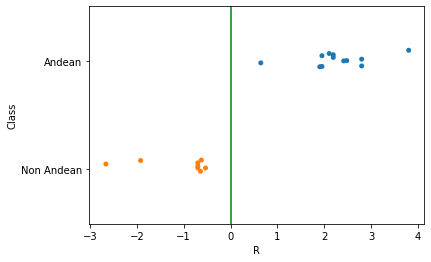

In [17]:
# now plot how representative these phonemes are of the Andean core, according to the classifier,
# as a function of which category they fell in according to Michael et al.
ax = sns.stripplot(x="R", y="Class", data=df)
ax.axvline(x=0, color='green')
plt.show()

### Replication achieved w.r.t. phoneme status!

That is, our classifer agrees with Michael et al. w.r.t. which phonemes are distinctively associated with the Andean core, and which are distinctively associated with the non-core &mdash; at least for the specific phonemes we examined above.  So far, so good.

Now what about the languages in the test set?  How are they classified by our classifier, based on their phoneme inventories?  In other words, returning to the "core plus periphery" idea, which languages in the periphery (our test set) are "core-like" in their phoneme inventories?

This is easy to find out.  For each language in the test set, with feature vector $X$, we ask how "core-like" our classifier considers it to be by computing $P(y=A | X)$.  Luckily for us, <span style="font-family:Courier">predict_proba(X)</span> within <span style="font-family:Courier">BernoulliNB</span> returns probability estimates for the test vector X, i.e. exactly the quantity we want.

In [19]:
# for each language in the test set, find its probability of being classified as "core" vs. not.
# use predict_proba(X) - see documentation:
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html
# then create df y_pred_probs containing, for each item X in test set, p(A|X) and p(C|X).

# YOUR CODE GOES HERE.
y_pred_probs = pd.DataFrame(fit_model.predict_proba(X_test), columns=["A","C"]).round(6)
y_pred_probs

,A,C
0,0.000001,0.999999
1,0.000077,0.999923
2,0.000000,1.000000
3,0.000000,1.000000
4,0.000000,1.000000
...,...,...
216,0.000000,1.000000
217,0.000000,1.000000
218,0.000000,1.000000
219,0.000000,1.000000


In [20]:
# now merge these predicted class probabilities into the df test that we created earlier.
# first remind yourself what test looks like.
test

,name,iso,p,t,c,k,q,m,n,ɲ,...,ɐ̃,bʲ,ɺ̥,r̥,h̃,c̰,k̰,ʒ̺,label,NBC_score
0,Abipon,axb,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,NaN,-16.13
1,Achagua,aca,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,NaN,-4.37
3,Achuar-Shiwiar,acu,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,NaN,-26.68
4,Aguaruna,agr,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,NaN,-31.13
5,Aikanã,tba,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,NaN,-35.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,Yukpa (de Irapa),yup_irp,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,NaN,-19.72
349,Yukpa (Macoíta),yup_mac,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,NaN,-18.86
350,Yuqui,yuq,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,NaN,-47.56
351,Yurakaré,yuz,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,1,NaN,-14.24


In [21]:
# now merge in the results of running our classifier on the test set.
results = test.reset_index(drop=True).merge(y_pred_probs, left_index=True, right_index=True)
results

,name,iso,p,t,c,k,q,m,n,ɲ,...,ɺ̥,r̥,h̃,c̰,k̰,ʒ̺,label,NBC_score,A,C
0,Abipon,axb,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,NaN,-16.13,0.000001,0.999999
1,Achagua,aca,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,NaN,-4.37,0.000077,0.999923
2,Achuar-Shiwiar,acu,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,NaN,-26.68,0.000000,1.000000
3,Aguaruna,agr,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,NaN,-31.13,0.000000,1.000000
4,Aikanã,tba,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,NaN,-35.30,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,Yukpa (de Irapa),yup_irp,1,1,0,1,0,1,1,0,...,0,0,0,0,0,0,NaN,-19.72,0.000000,1.000000
217,Yukpa (Macoíta),yup_mac,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,NaN,-18.86,0.000000,1.000000
218,Yuqui,yuq,1,1,0,1,0,1,1,1,...,0,0,0,0,0,0,NaN,-47.56,0.000000,1.000000
219,Yurakaré,yuz,1,1,0,1,0,1,1,1,...,0,0,0,0,0,1,NaN,-14.24,0.000000,1.000000


### Now consider each language as a whole

We now want to compare the NBC score for each language (as reported by Michael et al. in their Appendix C) with our classifier's output (as obtained here), and to do so across all languages in the test set.  There is a missing link here: the Michael et al. NBC score is their variable $s$ as defined in Equation 1 on their p. 12, whereas our output is $P(y|X)$.  Fortunately these two quantities are easily linked.  Michael et al. point out (pp. 14-15) that in the 2-class case, which we are in:

\begin{equation}
P(y=A|X) = \frac{1}{1+\exp(-s)}
\end{equation}

So we will now apply that transformation to get values for $P(y|X)$ that are based on Michael et al.'s reported NBC (or $s$) scores, and compare those to our values for $P(y|X)$, across languages.

In [26]:
# apply the above transformation, store results in df results.

# YOUR CODE GOES HERE.
results["probA"] = 1 / (1 + np.exp(-results["NBC_score"]))

# rt = results, trimmed
rt = results[['name', 'iso', 'label', 'NBC_score', 'probA', 'A']]
rt

,name,iso,label,NBC_score,probA,A
0,Abipon,axb,NaN,-16.13,9.881661e-08,0.000001
1,Achagua,aca,NaN,-4.37,1.249319e-02,0.000077
2,Achuar-Shiwiar,acu,NaN,-26.68,2.588351e-12,0.000000
3,Aguaruna,agr,NaN,-31.13,3.022823e-14,0.000000
4,Aikanã,tba,NaN,-35.30,4.670945e-16,0.000000
...,...,...,...,...,...,...
216,Yukpa (de Irapa),yup_irp,NaN,-19.72,2.727174e-09,0.000000
217,Yukpa (Macoíta),yup_mac,NaN,-18.86,6.444750e-09,0.000000
218,Yuqui,yuq,NaN,-47.56,2.212863e-21,0.000000
219,Yurakaré,yuz,NaN,-14.24,6.541032e-07,0.000000


In [27]:
# spot-check a few lgs that michael et al. consider strongly vs. weakly "core-like", from p. 22.
# some of these, e.g. 'ona', are actuallly not in the test set but rather training set.
# we have results here only for test set items.
strong = ['cbi', 'ccc', 'ame', 'vil', 'mca', 'cag', 'ona', 'ona_mtr', 'pue', 'teh']
weak = ['kbh', 'jeb', 'cbu', 'cpc', 'cpu', 'mtp', 'tob_tks', 'tob_lng', 'moc', 'alc_nth']
print("Languages considered by Michael et al. to be strongly core-like:")
display(rt[rt.iso.isin(strong)])
print("Languages considered by Michael et al. to be weakly core-like:")
display(rt[rt.iso.isin(weak)])

Languages considered by Michael et al. to be strongly core-like:


,name,iso,label,NBC_score,probA,A
45,Chamicuro,ccc,NaN,9.87,0.999948,0.921976
46,Cha'palaa,cbi,NaN,6.93,0.999023,0.860400
52,Chulupí,cag,NaN,5.72,0.996731,0.991840
116,Maka,mca,NaN,9.51,0.999926,0.999916
198,Vilela,vil,NaN,6.74,0.998819,0.850351
209,Yánesha,ame,NaN,22.61,1.000000,1.000000


Languages considered by Michael et al. to be weakly core-like:


,name,iso,label,NBC_score,probA,A
18,Ashéninka (Apurucayali dialect),cpc,NaN,3.06,0.955212,0.998948
20,Ashéninka (Pichis dialect),cpu,NaN,1.51,0.819061,0.949463
34,Camsá,kbh,NaN,5.03,0.993504,0.667561
35,Candoshi-Shapra,cbu,NaN,2.99,0.952120,0.948481
126,Mocoví,moc,NaN,1.97,0.877611,0.026490
172,Shiwilu,jeb,NaN,3.53,0.971529,0.847805
186,Toba (Lañagashik dialect),tob_lng,NaN,0.54,0.631812,0.001400
187,Toba (Takshek dialect),tob_tks,NaN,5.11,0.994000,0.481596
204,Wichí (Mision la Paz dialect),mtp,NaN,3.61,0.973661,0.999870


### Consider all languages, and compare our results to those of Michael et al.

In the spot-check above, we find that our results match those of Michael et al. well for some languages, but not so well for others.  This should not be entirely surprising, since the specifics our treatment necessarily deviated from theirs, as noted above.  

Given that there both similarities and differences, it would be good to get an overall sense of how well or poorly the two sets of results align.

In [28]:
# how well do the results of michael et al. (probA) correlate with ours (A)?
rt[["probA", "A"]].corr(method="pearson")

,probA,A
probA,1.000000,0.832182
A,0.832182,1.000000


### Observations and conclusions

Please specify what you found (your observations), and separately, what broader inferences you may draw from that (your conclusions).

##### Observations:
- In general, there is a strong correlation (0.83) between our results and Michael et al.'s, indicating that our classfier has largely replicated Michael et al.'s findings.
- But there are still some noticeable differences: some strongly core-like langauges in Michael et al.'s findings are not in our results, e.g., Vilela and Cha'palaa; on the other hand, some weakly core-like languages in Michael et al.'s findings are in fact quite strongly core-like in our findings, e.g., Ashéninka (Apurucayali dialect) and Wichí (Mision la Paz dialect).

##### Conclusions:
- Naive Bayes classifier generally does a good job in "learning" the phonological features typical for Andean core languages and apply these learned likelihoods to periphery languages and infer the probability each language belongs to Andean core and control class.
- Small changes in things like smoothing method can lead to significant differences in final results of Naive Bayes, one possible reason is the cumulation of small differences in each feature.